In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import *
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras.layers import Activation
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [0]:
from numpy.random import seed
seed(114)

In [0]:

# Load dataset
(x_train, y_train0), (x_test, y_test0) = mnist.load_data()

# Reshape size
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Normalize the range of featurs
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

In [0]:
x = Input(shape=(784,))

In [0]:
enc_1 = tfa.layers.WeightNormalization(Dense(512, activation='sigmoid'))
enc_2 = tfa.layers.WeightNormalization(Dense(256, activation='sigmoid'))
enc_3 = tfa.layers.WeightNormalization(Dense(128, activation='sigmoid'))

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_3 = tfa.layers.WeightNormalization(Dense(128, activation='sigmoid'))
dec_2 = tfa.layers.WeightNormalization(Dense(256, activation='sigmoid'))
dec_1 = tfa.layers.WeightNormalization(Dense(784, activation='sigmoid'))

In [0]:
x = Input(shape=(784,))
enc_x = enc_3(enc_2(enc_1(x)))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon    

In [0]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [0]:
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(z_input)))

In [11]:
x_hat = dec_1(dec_2(dec_3(z)))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
weight_normalization (WeightNor (None, 512)          804353      input_2[0][0]                    
__________________________________________________________________________________________________
weight_normalization_1 (WeightN (None, 256)          262913      weight_normalization[0][0]       
__________________________________________________________________________________________________
weight_normalization_2 (WeightN (None, 128)          65921       weight_normalization_1[0][0]     
______________________________________________________________________________________________

In [0]:
reconstruction_loss = 784 * tf.keras.losses.mse(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [13]:
VAE.compile(optimizer=Adam(1e-3))
history = VAE.fit(x_train, batch_size = 512, epochs = 20)

Epoch 1/20
118/118 [==============================] - 1s 11ms/step - loss: 59.0136
Epoch 2/20
118/118 [==============================] - 1s 11ms/step - loss: 48.0009
Epoch 3/20
118/118 [==============================] - 1s 11ms/step - loss: 44.8057
Epoch 4/20
118/118 [==============================] - 1s 11ms/step - loss: 43.1895
Epoch 5/20
118/118 [==============================] - 1s 11ms/step - loss: 42.1209
Epoch 6/20
118/118 [==============================] - 1s 11ms/step - loss: 41.2171
Epoch 7/20
118/118 [==============================] - 1s 11ms/step - loss: 40.6140
Epoch 8/20
118/118 [==============================] - 1s 11ms/step - loss: 40.1142
Epoch 9/20
118/118 [==============================] - 1s 11ms/step - loss: 39.6192
Epoch 10/20
118/118 [==============================] - 1s 11ms/step - loss: 39.2734
Epoch 11/20
118/118 [==============================] - 1s 11ms/step - loss: 38.9543
Epoch 12/20
118/118 [==============================] - 1s 11ms/step - loss: 38.6132
E

In [14]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
weight_normalization (Weight (None, 512)               804353    
_________________________________________________________________
weight_normalization_1 (Weig (None, 256)               262913    
_________________________________________________________________
weight_normalization_2 (Weig (None, 128)               65921     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 1,133,445
Trainable params: 567,298
Non-trainable params: 566,147
_________________________________________________________________


In [15]:
VAE_Decoder = Model(z_input, dec_1(dec_2(dec_3(z_input))))
VAE_Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
weight_normalization_3 (Weig (None, 128)               897       
_________________________________________________________________
weight_normalization_4 (Weig (None, 256)               66305     
_________________________________________________________________
weight_normalization_5 (Weig (None, 784)               403761    
Total params: 470,963
Trainable params: 236,064
Non-trainable params: 234,899
_________________________________________________________________


In [16]:
idx = np.random.randint(x_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(x_train[idx: idx+1]).squeeze()}")

第 32255 圖的 latent 表示為 [0.36388057 0.40503463]


In [0]:
indices = np.random.randint(x_train.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(x_train[indices])

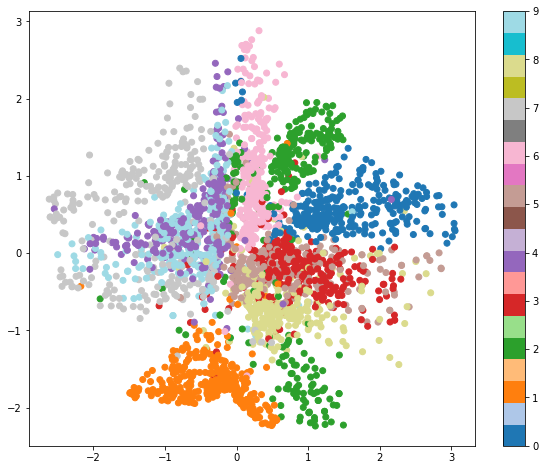

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [0]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [0]:
n = 13 ##13
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

In [0]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))

In [0]:
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

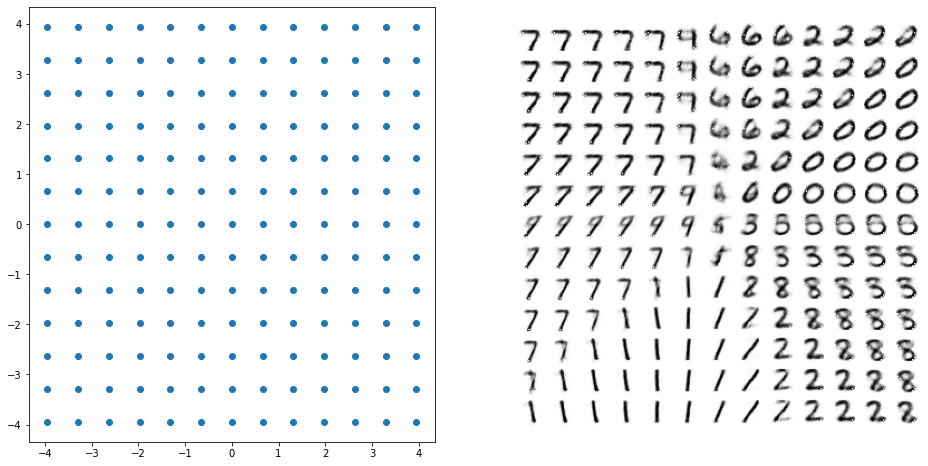

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()